In [1]:
import os
import glob
import random
import numpy as np
from keras import optimizers
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.layers.wrappers import TimeDistributed
from keras.applications.mobilenet import MobileNet
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
path = '../datasets/'
allfiles = glob.glob(path+'sensory/tile/*.npy')
sali = glob.glob(path+'content/saliencyImages/*.npy')
motion = glob.glob(path+'content/motionImages/*.npy')
prob = glob.glob(path+'sensory/tileProb/*.npy')

In [4]:
path = '../datasets/'
allfiles = glob.glob(path+'sensory/tile/*.npy')
sali = glob.glob(path+'content/saliencyImages/*.npy')
motion = glob.glob(path+'content/motionImages/*.npy')
prob = glob.glob(path)

def myGenerator():
    while True:
        index_list = random.sample(range(1, 30000), 10)
        alldata_x = []
        alldata_y = []
        for i in index_list:
            f = allfiles[i]
            s = f.split('_')
            saliFile = '../datasets/content/saliencyImages/'+s[0][25:]+'_saliency_'+s[2].split('.')[0]+'.npy'
            motionFile = '../datasets/content/motionImages/'+s[0][25:]+'_motion_'+s[2].split('.')[0]+'.npy'
            probFile = '../datasets/sensory/tileProb/'+s[0][25:]+'_user'+s[1][4:]+'_'+s[2].split('.')[0]+'.npy'
            a = np.load(f)
            b = np.load(saliFile)
            c = np.load(motionFile)
            d = [a, b, c]
            alldata_x.append(d)
            alldata_y.append(np.load(probFile))
        alldata_x = np.array(alldata_x)
        alldata_x = np.rollaxis(alldata_x, 1, 5)  
        #alldata_x = alldata_x.reshape((32, 30, 240, 480, 3))
        #alldata_x = np.swapaxes(alldata_x, 1, 4)
        alldata_y = np.array(alldata_y)
        yield alldata_x, alldata_y
# x = myGenerator()
# xtrain, ytrain = next(x)
# print('xtrain shape:',xtrain.shape)
# print('ytrain shape:',ytrain.shape)

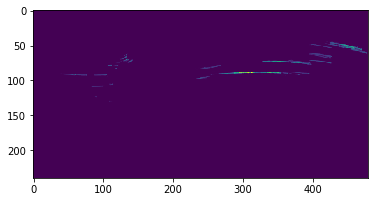

In [31]:
import matplotlib.pyplot as plt
plt.imshow(xtrain[0, 0][:, :, 2])

In [12]:
print(allfiles[1])
f = allfiles[1]
s = f.split('_')
print(s)
print('../datasets/sensory/tileProb/'+s[0][25:]+'_user'+s[1][4:]+'_'+s[2].split('.')[0]+'.npy')

../datasets/sensory/tile/landscape_user09_54.npy
['../datasets/sensory/tile/landscape', 'user09', '54.npy']
../datasets/sensory/tileProb/landscape_user09_54.npy


In [2]:
path = '../datasets/'
videoNames = os.listdir(path+'content/saliency/')
videoNames = [i[:-13] for i in videoNames]

In [3]:
# load the numpy arrays from saliency, motion maps and sensor data
sali = glob.glob(path+'content/saliencyImages/*.npy')
motion = glob.glob(path+'content/motionImages/*.npy')
sensory = glob.glob(path+'sensory/tile/*.npy')

In [5]:
from __future__ import absolute_import
from __future__ import print_function
import os
import numpy as np
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.utils import np_utils
from keras.applications import imagenet_utils

input_shape=(30, 240, 480, 3)
def mySegNet(input_shape):
    base_model  = MobileNet(input_shape=(224,224,3), include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs=base_model.input, outputs=x)
    
    model = Sequential();
    model.add(TimeDistributed(cnn_model, input_shape=input_shape))
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(200, return_sequences=True))
    model.compile(optimizer='adam', loss='mean_squared_error')
    #print(model.summary())
    return model
    

#mySegNet(input_shape)

In [ ]:
input_shape=(30, 240, 480, 3)
model = mySegNet(input_shape)
model.fit_generator(generator=myGenerator(),
                    use_multiprocessing=True,
                   steps_per_epoch=5, nb_epoch=5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., steps_per_epoch=5, epochs=5, use_multiprocessing=True)`
  """


Epoch 1/5


In [5]:
base_model  = VGG16(input_shape=(224,224,3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
cnn_model = Model(inputs=base_model.input, outputs=x)
print(cnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
videoNames = sorted(videoNames)[5:]
print(videoNames)
#print(sorted(sali))

for video in videoNames:
    npys = [s for s in sali if video in s]
    for npy in npys:
        data = np.load(npy)
        print(data.shape)
        break
    break

['landscape', 'pacman', 'panel', 'ride', 'sport']
(150, 1920, 3840)


In [16]:
# get the pre-trained VGG model
def loadVGG16Model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    #print ("Model loaded..!")
    #print (base_model.summary())
    return base_model
vgg_model = loadVGG16Model()


In [2]:
def getBaseModel():
    #base_model  = MobileNet(input_shape=(224,224,3), include_top=False)
    #base_model  = ResNet50(input_shape=(224,224,3), include_top=False)
    base_model  = VGG16(input_shape=(224,224,3), include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    sgd = optimizers.SGD(lr=0.0001)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    print (model.summary())
    return model
getBaseModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
def buildModel(): 
    nFilters=32
    kernelSize=(3,3)
    poolSize=(2,2)
    batchSize=64

    model=Sequential()

    model.add(TimeDistributed(Conv2D(40, (3, 3), activation='relu'), input_shape=[224, 224, 1]))
    #model.add(TimeDistributed(Conv2D(nFilters, kernel_size = kernelSize, activation="relu"), input_shape=[1920, 3840,1]))
    model.add(TimeDistributed(Conv2D(nFilters*2, kernel_size = kernelSize, activation="relu")))
    model.add(TimeDistributed(MaxPooling2D(pool_size=poolSize)))

    model.add(TimeDistributed(Conv2D(nFilters, kernel_size = kernelSize, activation="relu")))
    model.add(TimeDistributed(Conv2D(nFilters*2, kernel_size = kernelSize, activation="relu")))
    model.add(TimeDistributed(MaxPooling2D(pool_size=poolSize)))

    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(5))
    #model.add(Dense(, input_dim=, activation='relu'))
    print(model.summary())
    
    return model
model = buildModel()